## Chapter 4. Computer Vision with Convolutional Networks
### Intro
The intuition behind convolutional networks is that sensory information is often determined by their context. With images 
we are talking about nearby pixels in respect of a pixel of interest. 
Some interesting properties of CNNs:
* They connect neurons, which only correspond to neighboring pixels of the image. No all neurons are interconnected. 
* CNNs use **parameter sharing**, i.e. they share some weights.

### Convolutional layers
A convolutional layer consists of a set of filters (known as _kernels_ or _feature detectors_) where each filter is applied
across all areas of the input data. 
### Coding example of convolution

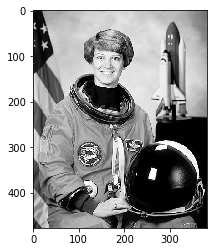

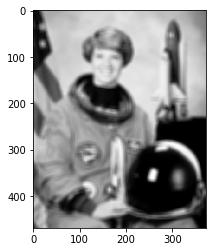

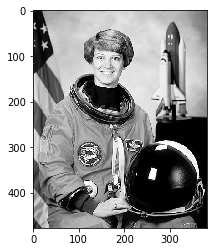

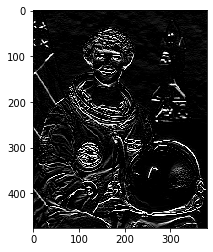

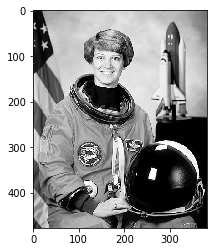

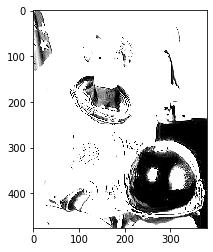

In [1]:
import numpy as np

def conv(image: np.ndarray, im_filter: np.ndarray):
    """
    Convolution implementation, works on grayscale images and 2D kernels.
    :param image: grayscale image as 2D numpy array
    :type image: np.ndarray
    :param im_filter: 2D numpy array representing the kernel
    :type im_filter: np.ndarray
    :rtype: None
    """
    # input dims
    height = image.shape[0]
    width = image.shape[1]
    # output image with reduced dimensions
    im_c = np.zeros((height - len(im_filter) + 1, width - len(im_filter) + 1))
    # iterate
    for row in range(len(im_c)):
        for col in range(len(im_c[0])):
            # apply filter
            for i in range(len(im_filter)):
                for j in range(len(im_filter[0])):
                    im_c[row, col] += image[row + i, col + j] * im_filter[i][j]
    
    # find out-of-bounds values
    im_c[im_c > 255] = 255
    im_c[im_c < 0] = 0
    # plot
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    my_cm = cm.get_cmap('Greys_r')
    
    plt.figure()
    plt.imshow(image, cmap=my_cm)
    plt.show()
    plt.imshow(im_c, cmap=my_cm)
    
import requests
from PIL import Image
from io import BytesIO

# load the image
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Commander_Eileen_Collins_-_GPN-2000-001177.jpg/382px-Commander_Eileen_Collins_-_GPN-2000-001177.jpg?download"
resp = requests.get(url)
image_rgb = np.asarray(Image.open(BytesIO(resp.content)).convert("RGB"))
# convert to grayscale
image_grayscale = np.mean(image_rgb, axis=2, dtype=np.uint)

# apply blur
blur = np.full([10, 10], 1. / 100)
conv(image_grayscale, blur)
# sobel edge detectors
sobel_x = [[-1, -2, -1],
           [0, 0, 0],
           [1, 2, 1]]
conv(image_grayscale, sobel_x)

sobel_y = [[-1, 9, 1],
           [-2, 0, 2],
           [-1, 0, 1]]
conv(image_grayscale, sobel_y)

### Basic properties of CNNs
Let's imagine a network using 3x3 convolutions with stride 1 and 2x2 pooling with stride 2
* The neurons of the first convolutional layer receives inputs from 3x3 pixels if the image
* A group of 2x2 output neurons of the first layer will have combined receptive field size of 4x4 because of the stride
* After the first pooling operation, this group will be combined in a single neuron of the pooling layer
* The second convolution operation takes input from 3x3 pooling neurons. It will receive input from a square with side 3x4
= 12 (or a total of 12x12 = 144 pixels).
* Convolutional layers extract features from the input. This information is very high-level in the deepest layers

### Classifying handwritten digits with a CNN

In [3]:
from numpy.random import seed
seed(0)
import tensorflow
tensorflow.random.set_seed(0)

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten
import tensorflow.keras.utils as np_utils

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)
# Let's define the net
mdl = Sequential([
    Convolution2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1)),
    Activation('relu'),
    Convolution2D(filters=32, kernel_size=(3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64),
    Activation('relu'),
    Dense(10),
    Activation('softmax')
])
print(mdl.summary())
# optimizer
mdl.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# train
mdl.fit(X_train, Y_train, batch_size=100, epochs=5, validation_split=0.1, verbose=1)
# evaluate
score = mdl.evaluate(X_test, Y_test, verbose=1)
print('test accuracy: {}'.format(score[1]))

# For some reason, using the suggested settings I get far lower accuracy than what is reported by the book (70-75% vs
# 98%). If I switch the optimizer from the suggested adadelta to adam, I get much higher accuracy.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_8 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

### Improving the performance of CNNs
There are several techniques to improve the performance of our model.
#### Data pre-processing


### A CNN example with Keras and CIFAR-10
We'll now try a complete example with data augmentation.

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

batch_size = 50
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)
# data augmentation
data_generator = ImageDataGenerator(rotation_range=90, width_shift_range=0.1, height_shift_range=0.1, featurewise_center=True,
                                    featurewise_std_normalization=True, horizontal_flip=True)
data_generator.fit(X_train)
# standardize test set
for i in range(len(X_test)):
    X_test[i] = data_generator.standardize(X_test[i])
    
# net arch
mdl = Sequential()
mdl.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
mdl.add(BatchNormalization())
mdl.add(Activation('elu'))
mdl.add(Conv2D(32, (3, 3), padding='same'))
mdl.add(BatchNormalization())
mdl.add(Activation('elu'))
mdl.add(MaxPooling2D(pool_size=(2, 2)))
mdl.add(Dropout(0.2))

mdl.add(Conv2D(64, (3, 3), padding='same'))
mdl.add(BatchNormalization())
mdl.add(Activation('elu'))

mdl.add(Conv2D(64, (3, 3), padding='same'))
mdl.add(BatchNormalization())
mdl.add(Activation('elu'))
mdl.add(MaxPooling2D(pool_size=(2, 2)))
mdl.add(Dropout(0.2))

mdl.add(Conv2D(128, (3, 3), padding='same'))
mdl.add(BatchNormalization())
mdl.add(Activation('elu'))
mdl.add(Conv2D(128, (3, 3), padding='same'))
mdl.add(BatchNormalization())
mdl.add(Activation('elu'))
mdl.add(MaxPooling2D(pool_size=(2, 2)))
mdl.add(Dropout(0.5))

mdl.add(Flatten())
mdl.add(Dense(10, activation='softmax'))
# optimizer
mdl.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# train
mdl.fit_generator(
    generator=data_generator.flow(x=X_train, y=Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=100,
    validation_data=(X_test, Y_test)
)

Epoch 1/100
1000/1000 [==============================] - 109s 109ms/step - loss: 1.9771 - accuracy: 0.3306 - val_loss: 1.9331 - val_accuracy: 0.3701